# Predictions for ERA5

In this example, we will download ERA5 data for 1 Jan 2023 at 0.25 degrees resolution and run Aurora on this data. The fine-tuned version of Aurora specifically only works with IFS HRES T0, so we use the non-fine-tuned version of Aurora in this example.

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install cdsapi matplotlib
```

## Downloading the Data

To begin with, register an account with the [Climate Data Store](https://cds.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

```
url: https://cds.climate.copernicus.eu/api
key: <API key>
```

You can find your API key on your account page.

In order to be able to download ERA5 data, you need to accept the terms of use in the [dataset page](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download).

We now download the ERA5 data.

In [1]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

2025-07-28 15:44:20,065 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [2]:
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for two steps, which produces predictions for hours 12:00 and 18:00.

In [3]:
from aurora import Aurora, rollout

model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

aurora-0.25-pretrained.ckpt:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

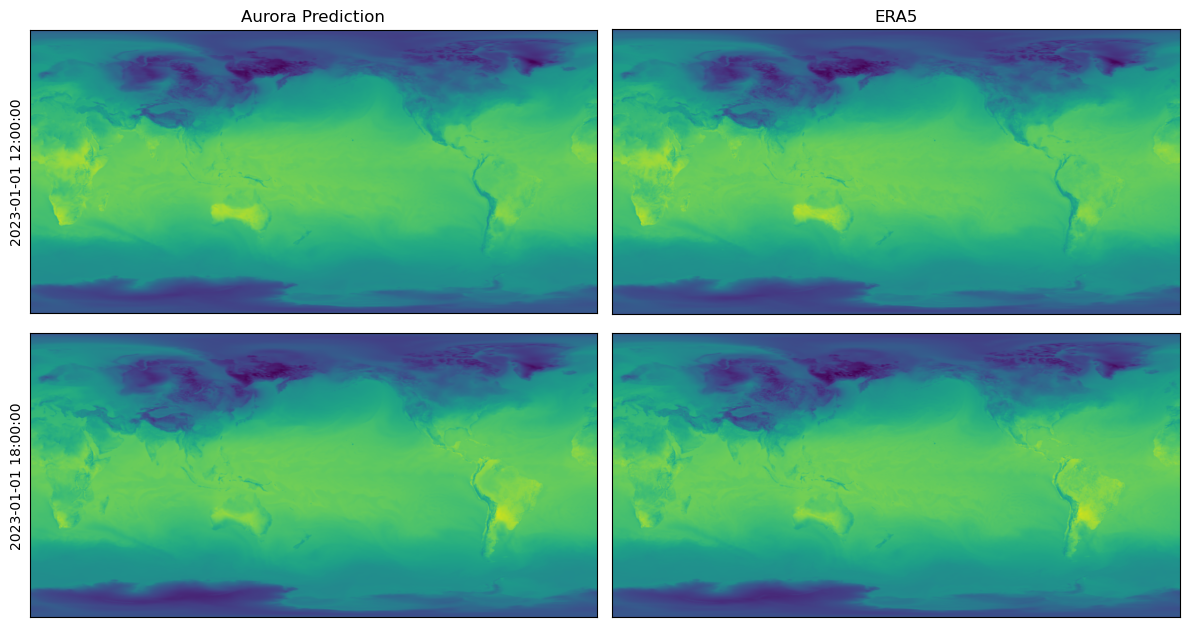

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()